In [1]:
import numpy as np
import pandas as pd
import sklearn as sk
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import BaggingClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
import pickle
import cupy
import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras import datasets, layers, models, utils
import cuml
import sys

np.random.seed(29)
sys.setrecursionlimit(50000)


2024-05-04 12:51:28.002707: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-04 12:51:28.939482: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/home/nvb/miniconda3/envs/rapids-24.04/lib/python3.11/site-packages/cudf/utils/_ptxcompiler.py:61: UserWarning: Error getting driver and runtime versions:

stdout:



stderr:

Traceback (most recent call last):
  File "/home/nvb/miniconda3/envs/rapids-24.04/lib/python3.11/site-packages/numba/cuda/cudadrv/driver.py", line 254, in ensure_initialized
    self.cuInit(0)
  File "/home/nvb/miniconda3/envs/rapids-24.04/lib/python3.11/site-packages/numba/cuda/cudadrv/driver.py", line 327, in safe_cuda_api_call
    self._check_ctypes_error(fname, retcode)
  File "/ho

In [2]:
from cuml.common.device_selection import set_global_device_type, get_global_device_type


initial_device_type = get_global_device_type()
set_global_device_type('gpu')
cuml.set_global_output_type('numpy')
print('default execution device:', initial_device_type)

default execution device: DeviceType.device


In [3]:
def imageConv(X,y):
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='valid', input_shape=(32, 32, 3)))
    model.add(layers.MaxPooling2D(pool_size=(2, 2)))
    model.add(layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='valid'))
    model.add(layers.MaxPooling2D(pool_size=(2, 2)))
    model.add(layers.Flatten())
    model.add(layers.Dense(units=10))
    model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.05),
                loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                metrics=[tf.keras.metrics.SparseCategoricalAccuracy()]) 
    model.fit(X, np.asarray(y), epochs=50,
            validation_split=0.2,
            callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_sparse_categorical_accuracy', patience=3, min_delta=0.001)], 
            batch_size=75, 
            verbose=2)
    
    convPreprModel=tf.keras.Sequential()

    for i in range(0,5):
        convPreprModel.add(model.layers[i])
        convPreprModel.layers[i].trainable=False

    convPreprModel.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.05),
                loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                metrics=[tf.keras.metrics.SparseCategoricalAccuracy()]) 

    newX=convPreprModel.predict(X)

    return newX
    """
    for datapoint in X:
        #xPrime=np.asarray(datapoint)
        #xPrime=np.insert(xPrime[0],0,values=32*32*3)
        newX.append(convPreprModel.predict(datapoint.reshape(1,32,32,3)))
    """

In [4]:
# Scales each feature to lie in [0, 1] and separate the data into training and
# test sets.

def preprocess_data(X, y):
    scaler = MinMaxScaler(feature_range=(0, 1))
    X = scaler.fit_transform(X)

    #This is horrible and I should be hanged for this, but it is 3am, If I look at documentation one more time.
    xLetters=[]
    for i in range(0,len(X)):
        for j in range (0,len(X[0])):
            if isinstance(X[i][j],str):
                xLetters.append(X[i][j])
    numOfChar=len(np.unique(xLetters))
    if numOfChar==1:
        replaceW=0.5
    else:
        replaceW=[i/(numOfChar-1) for i in range(0,numOfChar)]
    dictOfLetters={}
    s=0
    for i in range(0,len(X)):
        for j in range (0,len(X[0])):
            if isinstance(X[i][j],str):
                if X[i][j] in dictOfLetters.keys():
                    X[i][j]=dictOfLetters.get(X[i][j])
                else:
                    dictOfLetters[X[i][j]]=replaceW[s]
                    X[i][j]=replaceW[s]
                    s+=1
                    
    yLetters=[]
    for i in range(0,len(y)):
        if isinstance(y[i],str):
            yLetters.append(y[i])
    numOfChar=len(np.unique(yLetters))
    if numOfChar==1:
        replaceW=[1]
    else:
        replaceW=[i for i in range(0,numOfChar)]
    dictOfLetters={}
    s=0
    for i in range(0,len(y)):
        if isinstance(y[i],str):
            if y[i] in dictOfLetters.keys():
                y[i]=dictOfLetters.get(y[i])
            else:
                dictOfLetters[y[i]]=replaceW[s]
                y[i]=replaceW[s]
                s+=1

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15)
    return [X_train, X_test, y_train, y_test]

def unpickle(file):
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

In [5]:
dataset_names = ['wdbc', 'arrhythmia','DARWIN','CIFAR10']
dataset_arrays = []

data = pd.read_csv('breast+cancer+wisconsin+diagnostic/wdbc.data', header=None).to_numpy()
X = data[:, 2:31]
y = data[:, 1]
processed_data = preprocess_data(X, y)
dataset_arrays.append(processed_data)

data = pd.read_csv('arrhythmia/arrhythmia.data', header=None).replace('?', np.nan).to_numpy()
# Fills in missing values
imputer = SimpleImputer(missing_values=np.nan, strategy='mean')
data = imputer.fit_transform(data)
X = data[:, 0:278]
y = data[:, 279]
processed_data = preprocess_data(X, y)
dataset_arrays.append(processed_data)

data = pd.read_csv('DARWIN/data.csv', header=None).replace('?',np.nan).to_numpy()
X=data[1:,1:451]
y=data[1:,451]
processed_data = preprocess_data(X, y)
dataset_arrays.append(processed_data)

(cifar_train_images, cifar_train_labels), (cifar_test_images, cifar_test_labels) = datasets.cifar10.load_data()
"""
data=unpickle("cifar-10-batches-py/data_batch_1")
X=data.get(b"data")
y=data.get(b"labels")
processed_data = preprocess_data(X, y,True)
dataset_arrays.append(processed_data)
"""
cifar_train_images=imageConv(cifar_train_images,cifar_train_labels)
cifar_test_images=imageConv(cifar_test_images, cifar_test_labels)
dataset_arrays.append([cifar_train_images,cifar_test_images,cifar_train_labels,cifar_test_labels])
# Returns the dataset with given name
def get_dataset(name):
    i = dataset_names.index(name)
    return dataset_arrays[i]

/home/nvb/miniconda3/envs/rapids-24.04/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2024-05-04 12:51:31.833400: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-05-04 12:51:31.833996: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2251] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


Epoch 1/50
534/534 - 18s - 34ms/step - loss: 1251381215232.0000 - sparse_categorical_accuracy: 0.0995 - val_loss: 2.3029 - val_sparse_categorical_accuracy: 0.0977
Epoch 2/50
534/534 - 14s - 27ms/step - loss: 2.7078 - sparse_categorical_accuracy: 0.0987 - val_loss: 2.3030 - val_sparse_categorical_accuracy: 0.0952
Epoch 3/50
534/534 - 13s - 25ms/step - loss: 2.3327 - sparse_categorical_accuracy: 0.1004 - val_loss: 2.3030 - val_sparse_categorical_accuracy: 0.0952
Epoch 4/50
534/534 - 14s - 26ms/step - loss: 2.3054 - sparse_categorical_accuracy: 0.0959 - val_loss: 2.3030 - val_sparse_categorical_accuracy: 0.0977
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step
Epoch 1/50
107/107 - 3s - 26ms/step - loss: 412075.2812 - sparse_categorical_accuracy: 0.1026 - val_loss: 2.3033 - val_sparse_categorical_accuracy: 0.0920
Epoch 2/50
107/107 - 2s - 23ms/step - loss: 2.3029 - sparse_categorical_accuracy: 0.1016 - val_loss: 2.3033 - val_sparse_categorical_accuracy: 0.0920
Epoch 3/50
107/107 - 2s - 23ms/step 

In [6]:
class Models():

    def __init__(self, datasetName, maxIter, L2, nEstimators, bagging, modelTitle):
        """
        modelName: dataset to use
        maxIter: max iterations to train to
        L2: array of L2 regularization, None if no L2 reg.
        nEstimators: array of nEstimators, None if not doing Ensemble
        bagging: Fraction we want to test, None if no bagging
        modelTitle: Title for graphs, what is this model?
        """
        self.modelName=datasetName
        self.XTrain,self.XTest,self.yTrain,self.yTest=get_dataset(datasetName)
        self.XTrainGPU=cupy.asarray(self.XTrain,dtype=cupy.float32)
        self.yTrainGPU=cupy.asarray(self.yTrain,dtype=cupy.float32)
        self.XTestGPU=cupy.asarray(self.XTest,dtype=cupy.float32)
        self.yTestGPU=cupy.asarray(self.yTest,dtype=cupy.float32)
        self.maxIter=maxIter
        self.L2=L2
        self.nEstimators=nEstimators
        self.bagging=bagging
        self.modelTitle=modelTitle
        self.modelResults={}

    def getSoln(self):
        return self.modelResults

    def NEst(self, numEst):

        if self.bagging==None:
            return {"Bagging:None":self.BagFrac(None,numEst)}
        else:
            returnDic={}
            returnDic["Bagging:None"]=self.BagFrac(None,numEst)
            for frac in self.bagging:
                returnDic[f"Bagging:{frac}"]=self.BagFrac(frac,numEst)
        return returnDic

    def BagFrac(self, bagfrac,numEst):
        if self.L2==None:
            return {"L2:None":self.L2Reg(None,bagfrac,numEst)}
        else:
            returnDic={}
            returnDic["L2:None"]=self.L2Reg(None,bagfrac,numEst)
            for l2 in self.L2:
                returnDic[f"L2:{l2}"]=self.L2Reg(l2,bagfrac,numEst)
        return returnDic

    def L2Reg(self, l2,bagFrac,numEst):
        print(f"nest: {numEst}, bagfrac: {bagFrac}, l2: {l2}")
        if l2==None:
            base = cuml.LogisticRegression(penalty='none', max_iter=self.maxIter)
        else:
            base=cuml.LogisticRegression(penalty='none',max_iter=self.maxIter)#(penalty='l2',C=l2, max_iter=self.maxIter)
        if bagFrac==None and numEst==None:
            base.fit(self.XTrainGPU,self.yTrainGPU)
            return {"tr":base.score(self.XTrainGPU, self.yTrainGPU),
                "te":base.score(self.XTestGPU, self.yTestGPU)}
        elif bagFrac==None and numEst != None:
            classifier=BaggingClassifier(estimator=base, 
                                           n_estimators=numEst, 
                                           max_samples=1.0)

            classifier.fit(self.XTrain, [element for element in self.yTrain.ravel()])
            return {"tr":classifier.score(self.XTrain, [element for element in self.yTrain.ravel()]),
                "te":classifier.score(self.XTest, [element for element in self.yTest.ravel()])}
        elif bagFrac != None and numEst == None:
            classifier=BaggingClassifier(estimator=base, 
                                           n_estimators=1, 
                                           max_samples=bagFrac)

            classifier.fit(self.XTrain, [element for element in self.yTrain.ravel()])
            return {"tr":classifier.score(self.XTrain, [element for element in self.yTrain.ravel()]),
                "te":classifier.score(self.XTest, [element for element in self.yTest.ravel()])}
        else:
            bagging_classifier = BaggingClassifier(estimator=base, 
                                           n_estimators=numEst, 
                                           max_samples=bagFrac)
            bagging_classifier.fit(self.XTrain, [element for element in self.yTrain.ravel()])
            return {"tr":bagging_classifier.score(self.XTrain, [element for element in self.yTrain.ravel()]),
                "te":bagging_classifier.score(self.XTest, [element for element in self.yTest.ravel()])}

    def Train(self):
        """Does logical regression on data, returns training accuracy and test acc.
        can ignore output, saved to obj."""
        self.modelResults["NEst:None"]=self.NEst(None)
        if self.nEstimators!=None:
            for est in self.nEstimators:
                self.modelResults[f"NEst:{est}"]=self.NEst(est)

    def Graph(self,xaxis,include):
        """xAxis can be: NEST, L2, BAG
        include: NEST, L2, BAG, None; but not what was chosen as xaxis.[]
        """
        includeL2=False
        includeBAG=False
        includeNEST=False
        if "L2" in include:
            includeL2=True
        if "BAG" in include:
            includeBAG=True
        if "NEST" in include:
            includeNEST=True
        tr=[]
        te=[]
        ax=plt.gca()
        if xaxis=="NEST":
            if includeNEST:
                print("ERROR: xaxis cannot be the same as include")
                return None
            elif includeL2 and includeBAG:
                for bag in self.bagging:
                    for l2 in self.L2:
                        tr=[]
                        te=[]
                        for nEst in self.nEstimators:
                            tr.append(self.modelResults.get(f"NEst:{nEst}").get(f"Bagging:{bag}").get(f"L2:{l2}").get("tr"))
                            te.append(self.modelResults.get(f"NEst:{nEst}").get(f"Bagging:{bag}").get(f"L2:{l2}").get("te"))
                        colour = next(ax._get_lines.prop_cycler)['color']
                        plt.plot(self.nEstimators,tr,label=f"Train w/ Bag:{bag} L2:{l2}",linestyle="--",color=colour)
                        plt.plot(self.nEstimators,te,label=f"Test w/ Bag:{bag} L2:{l2}",linestyle="-",color=colour)
            elif includeL2:
                for l2 in self.L2:
                    tr=[]
                    te=[]
                    for nEst in self.nEstimators:
                        tr.append(self.modelResults.get(f"NEst:{nEst}").get(f"Bagging:None").get(f"L2:{l2}").get("tr"))
                        te.append(self.modelResults.get(f"NEst:{nEst}").get(f"Bagging:None").get(f"L2:{l2}").get("te"))
                    colour = next(ax._get_lines.prop_cycler)['color']
                    plt.plot(self.nEstimators,tr,label=f"Train w/ Bag:None L2:{l2}",linestyle="--",color=colour)
                    plt.plot(self.nEstimators,te,label=f"Test w/ Bag:None L2:{l2}",linestyle="-",color=colour)
            elif includeBAG:
                for bagFrac in self.bagging:
                    tr=[]
                    te=[]
                    for nEst in self.nEstimators:
                        tr.append(self.modelResults.get(f"NEst:{nEst}").get(f"Bagging:{bagFrac}").get(f"L2:None").get("tr"))
                        te.append(self.modelResults.get(f"NEst:{nEst}").get(f"Bagging:{bagFrac}").get(f"L2:None").get("te"))
                    colour = next(ax._get_lines.prop_cycler)['color']
                    plt.plot(self.nEstimators,tr,label=f"Train w/ Bag:{bagFrac} L2:None",linestyle="--",color=colour)
                    plt.plot(self.nEstimators,te,label=f"Test w/ Bag:{bagFrac} L2:None",linestyle="-",color=colour)
            else:
                pass

            #Plot None lines
            tr_OneEst=np.full(len(self.nEstimators), self.modelResults.get("NEst:None").get("Bagging:None").get("L2:None").get("tr"))
            te_OneEst=np.full(len(self.nEstimators), self.modelResults.get("NEst:None").get("Bagging:None").get("L2:None").get("te"))
            colour = next(ax._get_lines.prop_cycler)['color']
            plt.plot(self.nEstimators,tr_OneEst,label="Train w/o Bagging, L2, NumEst",linestyle="--",color=colour)
            plt.plot(self.nEstimators,te_OneEst,label="Test w/o Bagging, L2, NumEst",linestyle="-",color=colour)
        elif xaxis=="L2":
            if includeL2:
                print("ERROR: xaxis cannot be the same as include")
                return None
            elif includeNEST and includeBAG:
                for bag in self.bagging:
                    for nEst in self.nEstimators:
                        tr=[]
                        te=[]
                        for l2 in self.L2:
                            tr.append(self.modelResults.get(f"NEst:{nEst}").get(f"Bagging:{bag}").get(f"L2:{l2}").get("tr"))
                            te.append(self.modelResults.get(f"NEst:{nEst}").get(f"Bagging:{bag}").get(f"L2:{l2}").get("te"))
                        colour = next(ax._get_lines.prop_cycler)['color']
                        plt.plot(self.L2,tr,label=f"Train w/ Bag:{bag} nEst:{nEst}",linestyle="--",color=colour)
                        plt.plot(self.L2,te,label=f"Test w/ Bag:{bag} nEst:{nEst}",linestyle="-",color=colour)
            elif includeNEST:
                for nEst in self.nEstimators:
                    tr=[]
                    te=[]
                    for l2 in self.L2:
                        tr.append(self.modelResults.get(f"NEst:{nEst}").get(f"Bagging:None").get(f"L2:{l2}").get("tr"))
                        te.append(self.modelResults.get(f"NEst:{nEst}").get(f"Bagging:None").get(f"L2:{l2}").get("te"))
                    colour = next(ax._get_lines.prop_cycler)['color']
                    plt.plot(self.L2,tr,label=f"Train w/ Bag:None nEst:{nEst}",linestyle="--",color=colour)
                    plt.plot(self.L2,te,label=f"Test w/ Bag:None nEst:{nEst}",linestyle="-",color=colour)
            elif includeBAG:
                for bag in self.bagging:
                    tr=[]
                    te=[]
                    for l2 in self.L2:
                        tr.append(self.modelResults.get(f"NEst:None").get(f"Bagging:{bag}").get(f"L2:{l2}").get("tr"))
                        te.append(self.modelResults.get(f"NEst:None").get(f"Bagging:{bag}").get(f"L2:{l2}").get("te"))
                    colour = next(ax._get_lines.prop_cycler)['color']
                    plt.plot(self.L2,tr,label=f"Train w/ Bag:{bag} nEst:None",linestyle="--",color=colour)
                    plt.plot(self.L2,te,label=f"Test w/ Bag:{bag} nEst:None",linestyle="-",color=colour)
            else:
                pass

            #Plot None lines
            tr_OneEst=np.full(len(self.L2), self.modelResults.get("NEst:None").get("Bagging:None").get("L2:None").get("tr"))
            te_OneEst=np.full(len(self.L2), self.modelResults.get("NEst:None").get("Bagging:None").get("L2:None").get("te"))
            colour = next(ax._get_lines.prop_cycler)['color']
            plt.plot(self.L2,tr_OneEst,label="Train w/o Bagging, L2, NumEst",linestyle="--",color=colour)
            plt.plot(self.L2,te_OneEst,label="Test w/o Bagging, L2, NumEst",linestyle="-",color=colour)

        elif xaxis=="BAG":
            if includeBAG:
                print("ERROR: xaxis cannot be the same as include")
            elif includeL2 and includeNEST:
                for nEst in self.nEstimators:
                    for l2 in self.L2:
                        tr=[]
                        te=[]
                        for bag in self.bagging:
                            tr.append(self.modelResults.get(f"NEst:{nEst}").get(f"Bagging:{bag}").get(f"L2:{l2}").get("tr"))
                            te.append(self.modelResults.get(f"NEst:{nEst}").get(f"Bagging:{bag}").get(f"L2:{l2}").get("te"))
                        colour = next(ax._get_lines.prop_cycler)['color']
                        plt.plot(self.bagging,tr,label=f"Train w/ nEst:{nEst} L2:{l2}",linestyle="--",color=colour)
                        plt.plot(self.bagging,te,label=f"Test w/ nEst:{nEst} L2:{l2}",linestyle="-",color=colour)
            elif includeL2:
                for l2 in self.L2:
                    tr=[]
                    te=[]
                    for bag in self.bagging:
                        tr.append(self.modelResults.get(f"NEst:None").get(f"Bagging:{bag}").get(f"L2:{l2}").get("tr"))
                        te.append(self.modelResults.get(f"NEst:None").get(f"Bagging:{bag}").get(f"L2:{l2}").get("te"))
                    colour = next(ax._get_lines.prop_cycler)['color']
                    plt.plot(self.bagging,tr,label=f"Train w/ nEst:None L2:{l2}",linestyle="--",color=colour)
                    plt.plot(self.bagging,te,label=f"Test w/ nEst:None L2:{l2}",linestyle="-",color=colour)
            elif includeNEST:
                for nEst in self.nEstimators:
                    tr=[]
                    te=[]
                    for bag in self.bagging:
                        tr.append(self.modelResults.get(f"NEst:{nEst}").get(f"Bagging:{bag}").get(f"L2:None").get("tr"))
                        te.append(self.modelResults.get(f"NEst:{nEst}").get(f"Bagging:{bag}").get(f"L2:None").get("te"))
                    colour = next(ax._get_lines.prop_cycler)['color']
                    plt.plot(self.bagging,tr,label=f"Train w/ nEst:{nEst} L2:None",linestyle="--",color=colour)
                    plt.plot(self.bagging,te,label=f"Test w/ nEst:{nEst} L2:None",linestyle="-",color=colour)
            else:
                pass
        else:
            print("ERROR: incorrect xaxis value given")
        plt.legend(loc="best")
        box = ax.get_position()
        ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
        ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
        plt.title(f"{self.modelTitle} comparing {xaxis} to Acc w/ {include}")
        plt.xlabel(xaxis)
        plt.ylabel("Accuracy")
        plt.show()




In [15]:
def Graph(modelResults,xaxis,include,bagging,L2,nEstimators,modelTitle):
    """xAxis can be: NEST, L2, BAG
    include: NEST, L2, BAG, None; but not what was chosen as xaxis.[]
    """
    includeL2=False
    includeBAG=False
    includeNEST=False
    if "L2" in include:
        includeL2=True
    if "BAG" in include:
        includeBAG=True
    if "NEST" in include:
        includeNEST=True
    tr=[]
    te=[]
    ax=plt.gca()
    if xaxis=="NEST":
        if includeNEST:
            print("ERROR: xaxis cannot be the same as include")
            return None
        elif includeL2 and includeBAG:
            for bag in bagging:
                if bag==1:
                    pass
                for l2 in L2:
                    tr=[]
                    te=[]
                    for nEst in nEstimators:
                        tr.append(modelResults.get(f"NEst:{nEst}").get(f"Bagging:{bag}").get(f"L2:{l2}").get("tr"))
                        te.append(modelResults.get(f"NEst:{nEst}").get(f"Bagging:{bag}").get(f"L2:{l2}").get("te"))
                    colour = next(ax._get_lines.prop_cycler)['color']
                    plt.plot(nEstimators,tr,label=f"Train w/ Bag:{bag} L2:{l2}",linestyle="--",color=colour)
                    plt.plot(nEstimators,te,label=f"Test w/ Bag:{bag} L2:{l2}",linestyle="-",color=colour)
        elif includeL2:
            for l2 in L2:
                tr=[]
                te=[]
                for nEst in nEstimators:
                    tr.append(modelResults.get(f"NEst:{nEst}").get(f"Bagging:None").get(f"L2:{l2}").get("tr"))
                    te.append(modelResults.get(f"NEst:{nEst}").get(f"Bagging:None").get(f"L2:{l2}").get("te"))
                colour = next(ax._get_lines.prop_cycler)['color']
                plt.plot(nEstimators,tr,label=f"Train w/ Bag:None L2:{l2}",linestyle="--",color=colour)
                plt.plot(nEstimators,te,label=f"Test w/ Bag:None L2:{l2}",linestyle="-",color=colour)
        elif includeBAG:
            for bagFrac in bagging:
                if bagFrac==1:
                    pass
                tr=[]
                te=[]
                for nEst in nEstimators:
                    tr.append(modelResults.get(f"NEst:{nEst}").get(f"Bagging:{bagFrac}").get(f"L2:None").get("tr"))
                    te.append(modelResults.get(f"NEst:{nEst}").get(f"Bagging:{bagFrac}").get(f"L2:None").get("te"))
                colour = next(ax._get_lines.prop_cycler)['color']
                plt.plot(nEstimators,tr,label=f"Train w/ Bag:{bagFrac} L2:None",linestyle="--",color=colour)
                plt.plot(nEstimators,te,label=f"Test w/ Bag:{bagFrac} L2:None",linestyle="-",color=colour)
        else:
            pass

        #Plot None lines
        tr_OneEst=np.full(len(nEstimators), modelResults.get("NEst:None").get("Bagging:None").get("L2:None").get("tr"))
        te_OneEst=np.full(len(nEstimators), modelResults.get("NEst:None").get("Bagging:None").get("L2:None").get("te"))
        colour = next(ax._get_lines.prop_cycler)['color']
        plt.plot(nEstimators,tr_OneEst,label="Train w/o Bagging, L2, NumEst",linestyle="--",color=colour)
        plt.plot(nEstimators,te_OneEst,label="Test w/o Bagging, L2, NumEst",linestyle="-",color=colour)
    elif xaxis=="L2":
        if includeL2:
            print("ERROR: xaxis cannot be the same as include")
            return None
        elif includeNEST and includeBAG:
            for bag in bagging:
                for nEst in nEstimators:
                    tr=[]
                    te=[]
                    for l2 in L2:
                        tr.append(modelResults.get(f"NEst:{nEst}").get(f"Bagging:{bag}").get(f"L2:{l2}").get("tr"))
                        te.append(modelResults.get(f"NEst:{nEst}").get(f"Bagging:{bag}").get(f"L2:{l2}").get("te"))
                    colour = next(ax._get_lines.prop_cycler)['color']
                    plt.plot(L2,tr,label=f"Train w/ Bag:{bag} nEst:{nEst}",linestyle="--",color=colour)
                    plt.plot(L2,te,label=f"Test w/ Bag:{bag} nEst:{nEst}",linestyle="-",color=colour)
        elif includeNEST:
            for nEst in nEstimators:
                tr=[]
                te=[]
                for l2 in L2:
                    tr.append(modelResults.get(f"NEst:{nEst}").get(f"Bagging:None").get(f"L2:{l2}").get("tr"))
                    te.append(modelResults.get(f"NEst:{nEst}").get(f"Bagging:None").get(f"L2:{l2}").get("te"))
                colour = next(ax._get_lines.prop_cycler)['color']
                plt.plot(L2,tr,label=f"Train w/ Bag:None nEst:{nEst}",linestyle="--",color=colour)
                plt.plot(L2,te,label=f"Test w/ Bag:None nEst:{nEst}",linestyle="-",color=colour)
        elif includeBAG:
            for bag in bagging:
                tr=[]
                te=[]
                for l2 in L2:
                    tr.append(modelResults.get(f"NEst:None").get(f"Bagging:{bag}").get(f"L2:{l2}").get("tr"))
                    te.append(modelResults.get(f"NEst:None").get(f"Bagging:{bag}").get(f"L2:{l2}").get("te"))
                colour = next(ax._get_lines.prop_cycler)['color']
                plt.plot(L2,tr,label=f"Train w/ Bag:{bag} nEst:None",linestyle="--",color=colour)
                plt.plot(L2,te,label=f"Test w/ Bag:{bag} nEst:None",linestyle="-",color=colour)
        else:
            pass

        #Plot None lines
        tr_OneEst=np.full(len(L2), modelResults.get("NEst:None").get("Bagging:None").get("L2:None").get("tr"))
        te_OneEst=np.full(len(L2), modelResults.get("NEst:None").get("Bagging:None").get("L2:None").get("te"))
        colour = next(ax._get_lines.prop_cycler)['color']
        plt.plot(L2,tr_OneEst,label="Train w/o Bagging, L2, NumEst",linestyle="--",color=colour)
        plt.plot(L2,te_OneEst,label="Test w/o Bagging, L2, NumEst",linestyle="-",color=colour)

    elif xaxis=="BAG":
        if includeBAG:
            print("ERROR: xaxis cannot be the same as include")
        elif includeL2 and includeNEST:
            for nEst in nEstimators:
                for l2 in L2:
                    tr=[]
                    te=[]
                    for bag in bagging:
                        tr.append(modelResults.get(f"NEst:{nEst}").get(f"Bagging:{bag}").get(f"L2:{l2}").get("tr"))
                        te.append(modelResults.get(f"NEst:{nEst}").get(f"Bagging:{bag}").get(f"L2:{l2}").get("te"))
                    colour = next(ax._get_lines.prop_cycler)['color']
                    plt.plot(bagging,tr,label=f"Train w/ nEst:{nEst} L2:{l2}",linestyle="--",color=colour)
                    plt.plot(bagging,te,label=f"Test w/ nEst:{nEst} L2:{l2}",linestyle="-",color=colour)
        elif includeL2:
            for l2 in L2:
                tr=[]
                te=[]
                for bag in bagging:
                    tr.append(modelResults.get(f"NEst:None").get(f"Bagging:{bag}").get(f"L2:{l2}").get("tr"))
                    te.append(modelResults.get(f"NEst:None").get(f"Bagging:{bag}").get(f"L2:{l2}").get("te"))
                colour = next(ax._get_lines.prop_cycler)['color']
                plt.plot(bagging,tr,label=f"Train w/ nEst:None L2:{l2}",linestyle="--",color=colour)
                plt.plot(bagging,te,label=f"Test w/ nEst:None L2:{l2}",linestyle="-",color=colour)
        elif includeNEST:
            for nEst in nEstimators:
                tr=[]
                te=[]
                for bag in bagging:
                    tr.append(modelResults.get(f"NEst:{nEst}").get(f"Bagging:{bag}").get(f"L2:None").get("tr"))
                    te.append(modelResults.get(f"NEst:{nEst}").get(f"Bagging:{bag}").get(f"L2:None").get("te"))
                colour = next(ax._get_lines.prop_cycler)['color']
                plt.plot(bagging,tr,label=f"Train w/ nEst:{nEst} L2:None",linestyle="--",color=colour)
                plt.plot(bagging,te,label=f"Test w/ nEst:{nEst} L2:None",linestyle="-",color=colour)
        else:
            pass
    else:
        print("ERROR: incorrect xaxis value given")
    plt.legend(loc="best")
    box = ax.get_position()
    ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.xticks(np.arange(10, 160, step=10))
    plt.title(f"{modelTitle} comparing {xaxis} to Acc w/ {include}")
    plt.xlabel(xaxis)
    plt.ylabel("Accuracy")
    plt.show()

Guide:\
When creating model object params are:\
&nbsp;&nbsp;&nbsp;&nbsp;    datasetName = name of dataset from dataset_names array\
&nbsp;&nbsp;&nbsp;&nbsp;    maxIter = maxIterations allowed in model\
&nbsp;&nbsp;&nbsp;&nbsp;    L2 = array of L2 values we want to test (so C) [$C_1$,$C_2$,..]\
 &nbsp;&nbsp;&nbsp;&nbsp;   nEstimators = array of nEstimators we wanna test [5,10,100,etc]\
  &nbsp;&nbsp;&nbsp;&nbsp;  bagging = array of decimals for the bagging fraction we want to test [0.1,0.5,etc]\
  &nbsp;&nbsp;&nbsp;&nbsp;  modelTitle = name that will appear atop of graph. Helps w/ keeping graphs organized.\
  &nbsp;&nbsp;&nbsp;&nbsp;  \
When graphing params are: \
   &nbsp;&nbsp;&nbsp;&nbsp; *xaxis = will tell the program what we want on xaxis can be: NEST, BAG, L2 (self explanatory)\
 &nbsp;&nbsp;&nbsp;&nbsp;   *include = array telling the program what data we want plotted can be: NEST, BAG, L2\
  &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;      **IMPORTANT: whatever xaxis is cannot be included in the include array!\
   &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;     **E.g.\
   &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;     **model.Graph("NEST",["L2","BAG"])  -  will work, will tell program to put nEstimators on xaxis, and graph L2 and Bag values\
   &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; **model.Graph("NEST',["L2","BAG","NEST"])  -  will not work as NEST is already on the xaxis.

Example Below: Note, training will take time as you are training len(L2) x len(nEst) x len(bagging)

In [8]:
testModel=Models('wdbc',5000,[0.1,0.5,1,5,10,50,500],[10,15,20,40,60,80,120,160],[0.2,0.35,0.5,0.75,1],"wdbc")
testModel.Train()

nest: None, bagfrac: None, l2: None
nest: None, bagfrac: None, l2: 0.1
nest: None, bagfrac: None, l2: 0.5
nest: None, bagfrac: None, l2: 1
nest: None, bagfrac: None, l2: 5
nest: None, bagfrac: None, l2: 10
nest: None, bagfrac: None, l2: 50
nest: None, bagfrac: None, l2: 500
nest: None, bagfrac: 0.2, l2: None
nest: None, bagfrac: 0.2, l2: 0.1
nest: None, bagfrac: 0.2, l2: 0.5
nest: None, bagfrac: 0.2, l2: 1
nest: None, bagfrac: 0.2, l2: 5
nest: None, bagfrac: 0.2, l2: 10
nest: None, bagfrac: 0.2, l2: 50
nest: None, bagfrac: 0.2, l2: 500
nest: None, bagfrac: 0.35, l2: None
nest: None, bagfrac: 0.35, l2: 0.1
nest: None, bagfrac: 0.35, l2: 0.5
nest: None, bagfrac: 0.35, l2: 1
nest: None, bagfrac: 0.35, l2: 5
nest: None, bagfrac: 0.35, l2: 10
nest: None, bagfrac: 0.35, l2: 50
nest: None, bagfrac: 0.35, l2: 500
nest: None, bagfrac: 0.5, l2: None
nest: None, bagfrac: 0.5, l2: 0.1
nest: None, bagfrac: 0.5, l2: 0.5
nest: None, bagfrac: 0.5, l2: 1
nest: None, bagfrac: 0.5, l2: 5
nest: None, bagf

In [9]:
soln=testModel.getSoln()

In [10]:
print(soln)

{'NEst:None': {'Bagging:None': {'L2:None': {'tr': 1.0, 'te': 0.9651162624359131}, 'L2:0.1': {'tr': 1.0, 'te': 0.9651162624359131}, 'L2:0.5': {'tr': 1.0, 'te': 0.9534883499145508}, 'L2:1': {'tr': 1.0, 'te': 0.9534883499145508}, 'L2:5': {'tr': 1.0, 'te': 0.9534883499145508}, 'L2:10': {'tr': 1.0, 'te': 0.9651162624359131}, 'L2:50': {'tr': 1.0, 'te': 0.9534883499145508}, 'L2:500': {'tr': 1.0, 'te': 0.9651162624359131}}, 'Bagging:0.2': {'L2:None': {'tr': 0.979296066252588, 'te': 0.9534883720930233}, 'L2:0.1': {'tr': 0.9627329192546584, 'te': 0.9534883720930233}, 'L2:0.5': {'tr': 0.9648033126293996, 'te': 0.9534883720930233}, 'L2:1': {'tr': 0.94824016563147, 'te': 0.9302325581395349}, 'L2:5': {'tr': 0.9730848861283644, 'te': 0.9651162790697675}, 'L2:10': {'tr': 0.9585921325051759, 'te': 0.9534883720930233}, 'L2:50': {'tr': 0.9772256728778468, 'te': 0.9767441860465116}, 'L2:500': {'tr': 0.9585921325051759, 'te': 0.9767441860465116}}, 'Bagging:0.35': {'L2:None': {'tr': 0.9606625258799172, 'te'

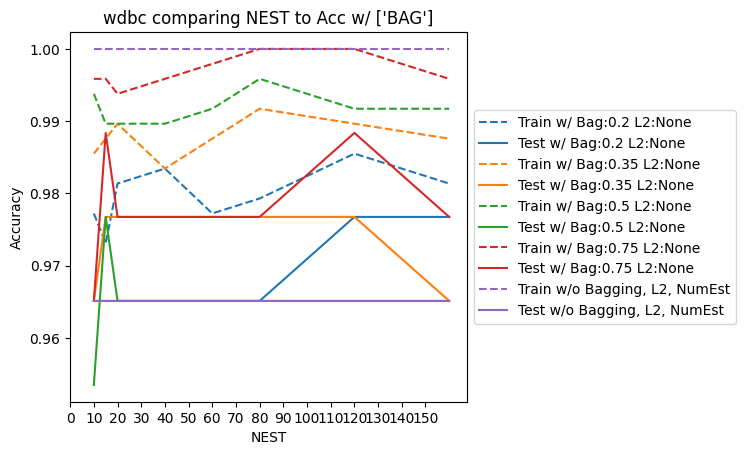

In [16]:
Graph(soln,"NEST",["BAG"],[0.2,0.35,0.5,0.75],[0.1,0.5,1,5,10,50,500],[10,15,20,40,60,80,120,160],"wdbc")

In [139]:
import matplotlib
print('matplotlib: {}'.format(matplotlib.__version__))

matplotlib: 3.8.4


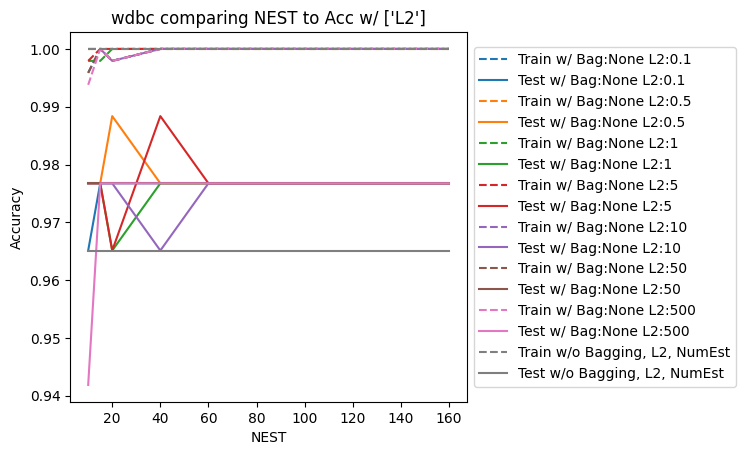

In [13]:
testModel.Graph('NEST',["L2"])

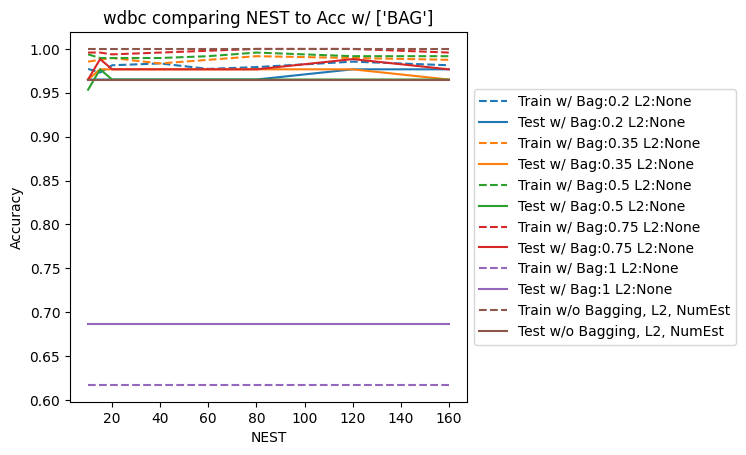

In [22]:
testModel.Graph('NEST',['BAG'])

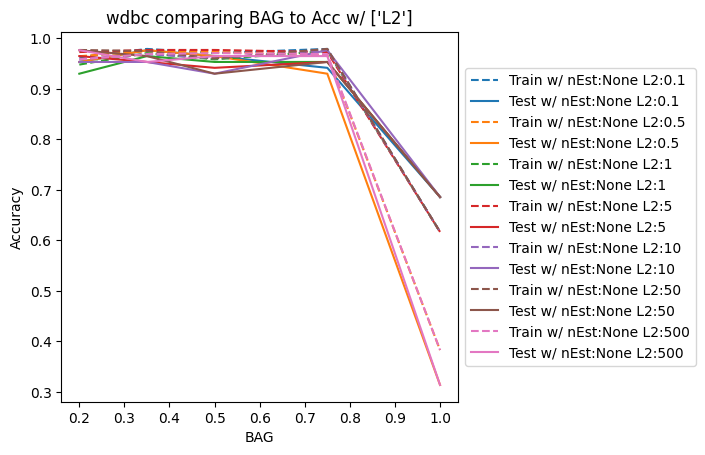

In [19]:
testModel.Graph('BAG',["L2"])

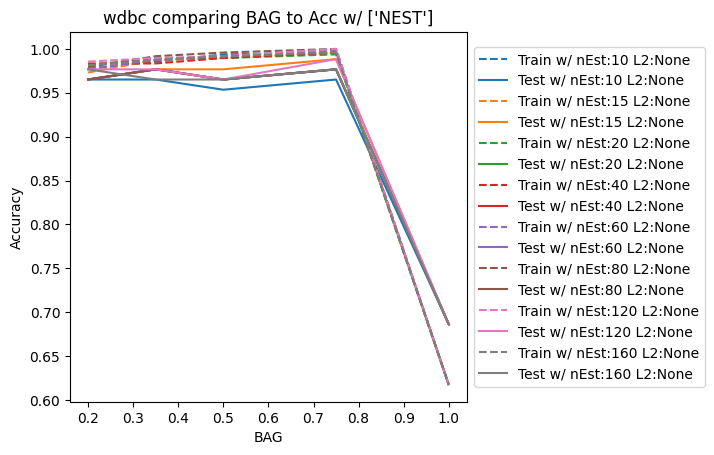

In [20]:
testModel.Graph('BAG',["NEST"])

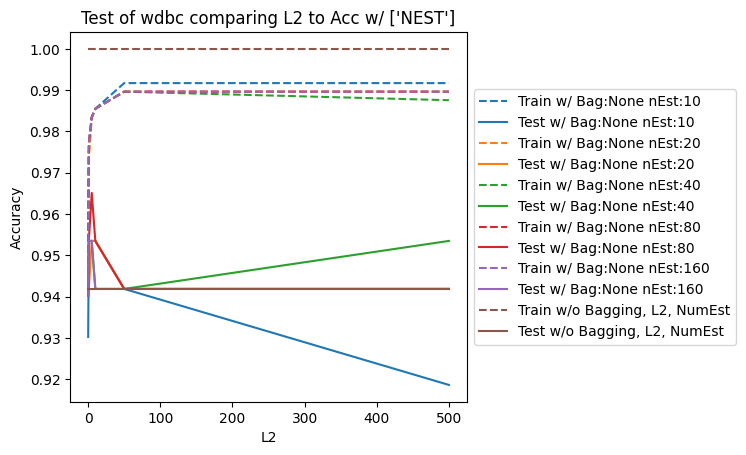

In [106]:
testModel.Graph('L2',["NEST"])

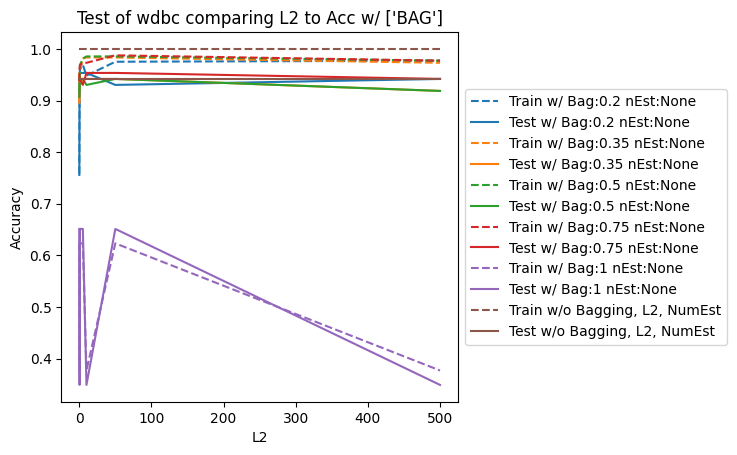

In [107]:
testModel.Graph('L2',["BAG"])

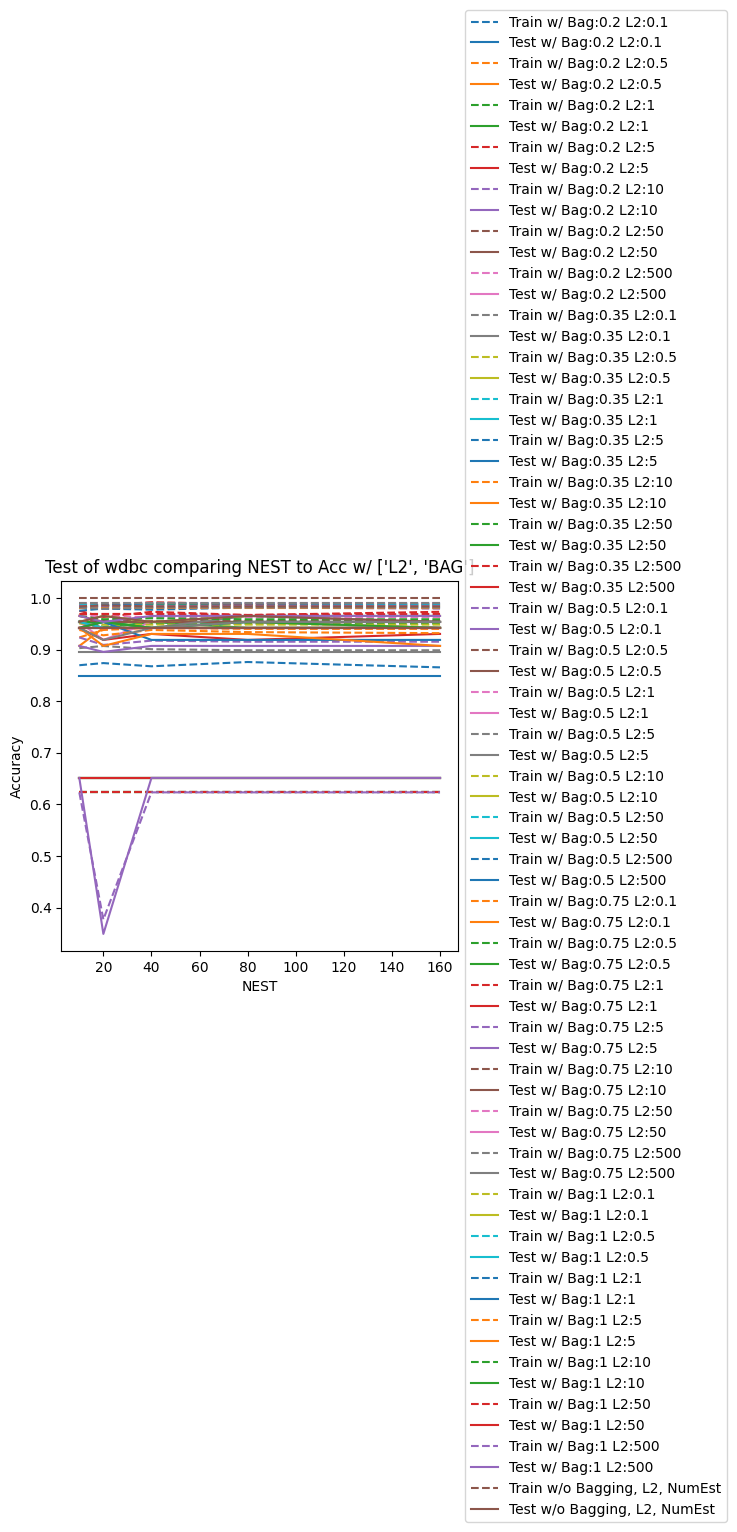

In [108]:
testModel.Graph('NEST',["L2","BAG"])

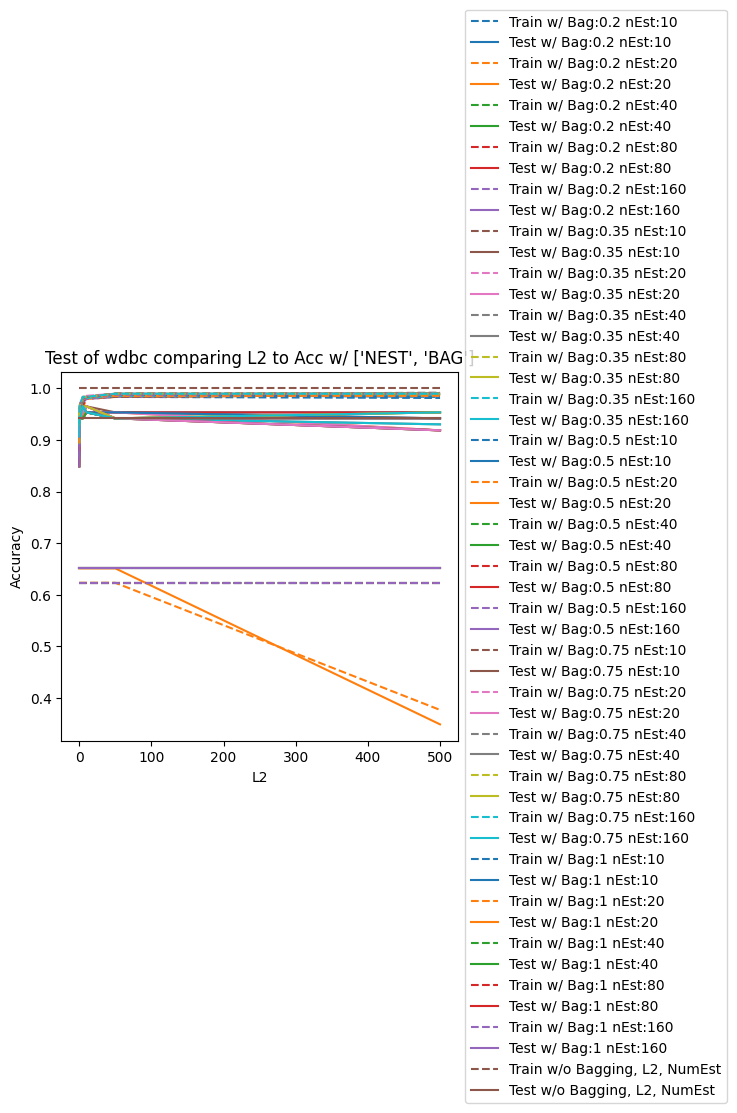

In [109]:
testModel.Graph('L2',["NEST","BAG"])

TypeError: 'NoneType' object is not iterable

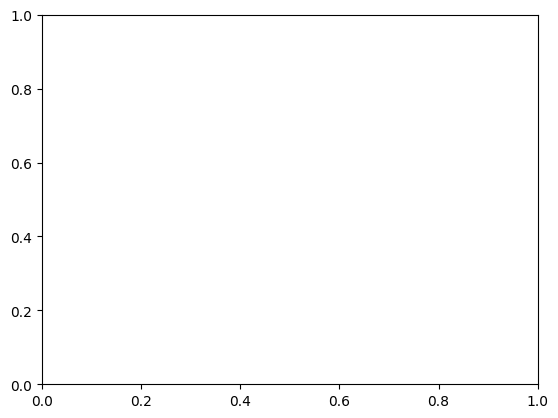

In [10]:
testModel.Graph('BAG',["L2","NEST"])

In [15]:
arrhythmiaModel=Models('arrhythmia',10000,[0.1,0.5,1,2.5,5,10,25,50,100,150,250,500],[5,10,20,50,100,200,1000],[0.1,0.25,0.5,0.75,1],"Arrhythmia")
arrhythmiaModel.Train()

[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    5.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    4.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    4.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    5.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Starting L2Reg


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    6.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    5.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    5.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    5.9s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    5.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    5.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    6.6s finished
[Parallel(n_jobs=-1)]: Using backend Loky

Starting L2Reg


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    7.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    7.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    8.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    7.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    7.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    7.9s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    6.7s finished
[Parallel(n_jobs=-1)]: Using backend Loky

Starting L2Reg


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.8s finished
[Parallel(n_jobs=-1)]: Using backend Loky

Starting L2Reg


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.8s finished
[Parallel(n_jobs=-1)]: Using backend Loky

Starting L2Reg


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.6s finished
[Parallel(n_jobs=-1)]: Using backend Loky

Starting L2Reg


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.6s finished
[Parallel(n_jobs=-1)]: Using backend Loky

Starting L2Reg


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.9s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.9s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.9s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.9s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.8s finished
[Parallel(n_jobs=-1)]: Using backend Loky

Starting L2Reg


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.3s finished
[Parallel(n_jobs=-1)]: Using backend Loky

Starting L2Reg


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.9s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    2.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    2.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    2.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    2.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    2.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    2.2s finished
[Parallel(n_jobs=-1)]: Using backend Loky

Starting L2Reg


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    2.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    2.9s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    3.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    3.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    2.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    3.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    2.7s finished
[Parallel(n_jobs=-1)]: Using backend Loky

Starting L2Reg


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    3.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    3.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    3.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    3.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    3.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    3.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    3.4s finished
[Parallel(n_jobs=-1)]: Using backend Loky

Starting L2Reg


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    4.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    4.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    3.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    3.9s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    3.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    4.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    3.5s finished
[Parallel(n_jobs=-1)]: Using backend Loky

Starting L2Reg


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    6.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    5.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    6.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    5.9s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    6.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    6.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    6.0s finished
[Parallel(n_jobs=-1)]: Using backend Loky

Starting L2Reg


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    5.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    6.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    5.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    4.9s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    4.9s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    5.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    4.5s finished
[Parallel(n_jobs=-1)]: Using backend Loky

Starting L2Reg


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    3.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    3.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    2.9s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    3.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    3.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    2.7s finished
[Parallel(n_jobs=-1)]: Using backend Loky

Starting L2Reg


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    2.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    2.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    2.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    4.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend Loky

Starting L2Reg


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:   20.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:   25.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:   23.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:   23.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:   24.3s finished
[Parallel(n_jobs=-1)]: Using backend Loky

Starting L2Reg


KeyboardInterrupt: 

TypeError: object of type 'NoneType' has no len()

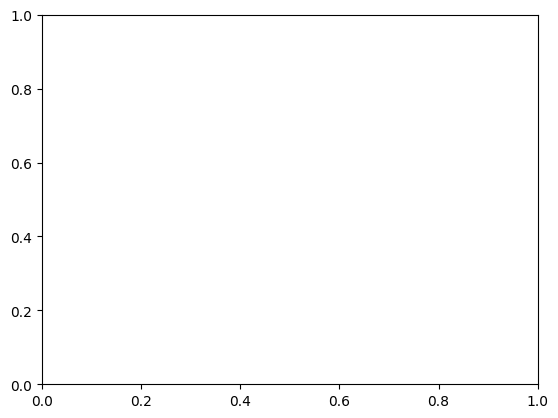

In [14]:
arrhythmiaModel.Graph("NEST",[None])







Previous Code

In [76]:
# Trains bagging model on top of logistic regression.
def bagging_log_regr(X_train, X_test, y_train, y_test, num_models, frac_samples, regularization=None):
    if (regularization == None):
        base = LogisticRegression(penalty=None, max_iter=5000)
    else:
        base = LogisticRegression(penalty='l2', C=regularization, max_iter=5000)
    bagging_classifier = BaggingClassifier(estimator=base, 
                                           n_estimators=num_models, 
                                           max_samples=frac_samples)
    bagging_classifier.fit(X_train, y_train)
    return bagging_classifier.score(X_train, y_train), bagging_classifier.score(X_test, y_test)

# Plots training and testing accuracy vs. number of base learners.
def plot_acc_vs_n_models(list_n_models, list_tr_acc, list_te_acc, nobag_tr_acc, nobag_te_acc):
    plt.plot(list_n_models, list_tr_acc, label='Train')
    plt.plot(list_n_models, list_te_acc, label='Test')
    nobag_tr = np.full(len(list_n_models), nobag_tr_acc)
    nobag_te = np.full(len(list_n_models), nobag_te_acc)
    plt.plot(list_n_models, nobag_tr, label='Train without bagging')
    plt.plot(list_n_models, nobag_te, label='Test without bagging')
    plt.legend(loc='best')
    plt.show()
    

1.0
0.9418604651162791
[0.9648033126293996, 0.9834368530020704, 0.9937888198757764, 0.989648033126294, 0.9917184265010351, 0.9917184265010351, 0.989648033126294]
[0.9418604651162791, 0.9302325581395349, 0.9534883720930233, 0.9418604651162791, 0.9418604651162791, 0.9418604651162791, 0.9418604651162791]


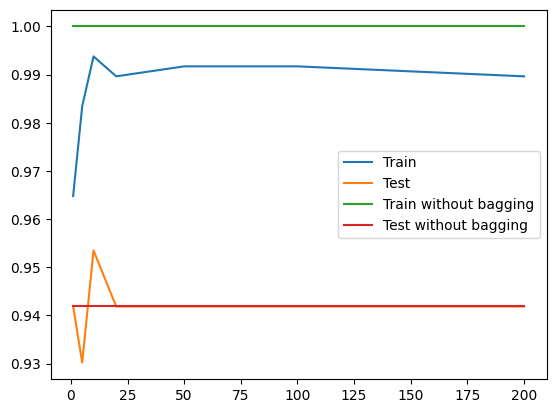

In [77]:
# Test on number of base learners

list_n_models = [1, 5, 10, 20, 50, 100, 200]

X_train, X_test, y_train, y_test = get_dataset('wdbc')

log_regr = LogisticRegression(penalty=None, max_iter=5000)
log_regr.fit(X_train, y_train)
nobag_tr_acc = log_regr.score(X_train, y_train)
nobag_te_acc = log_regr.score(X_test, y_test)
print(nobag_tr_acc)
print(nobag_te_acc)


list_tr_acc = []
list_te_acc = []
for n_models in list_n_models:
    tr_acc, te_acc = bagging_log_regr(X_train, X_test, y_train, y_test, n_models, 0.5)
    list_tr_acc.append(tr_acc)
    list_te_acc.append(te_acc)
print(list_tr_acc)
print(list_te_acc)
plot_acc_vs_n_models(list_n_models, list_tr_acc, list_te_acc, nobag_tr_acc, nobag_te_acc)

1.0
0.6617647058823529
[0.78125, 0.8541666666666666, 0.859375, 0.8880208333333334, 0.9010416666666666, 0.8932291666666666, 0.8958333333333334]
[0.6029411764705882, 0.6176470588235294, 0.6323529411764706, 0.6617647058823529, 0.6470588235294118, 0.6617647058823529, 0.6470588235294118]


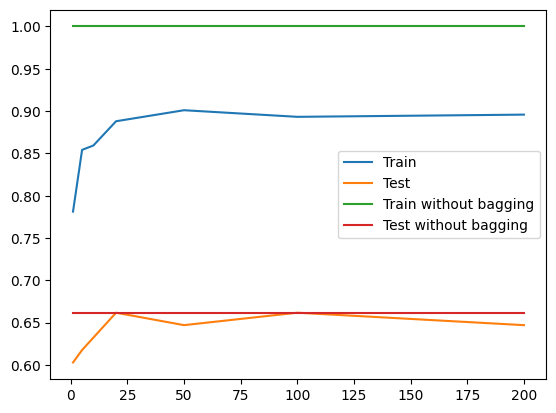

In [78]:
X_train, X_test, y_train, y_test = get_dataset('arrhythmia')

log_regr = LogisticRegression(penalty=None, max_iter=5000)
log_regr.fit(X_train, y_train)
nobag_tr_acc = log_regr.score(X_train, y_train)
nobag_te_acc = log_regr.score(X_test, y_test)
print(nobag_tr_acc)
print(nobag_te_acc)

list_tr_acc = []
list_te_acc = []
for n_models in list_n_models:
    tr_acc, te_acc = bagging_log_regr(X_train, X_test, y_train, y_test, n_models, 0.5)
    list_tr_acc.append(tr_acc)
    list_te_acc.append(te_acc)
print(list_tr_acc)
print(list_te_acc)
plot_acc_vs_n_models(list_n_models, list_tr_acc, list_te_acc, nobag_tr_acc, nobag_te_acc)


In [79]:
# Plots training and test accuracies vs number of examples used to train each base learners.
def plot_acc_vs_n_examples(list_n_examples, list_tr_acc, list_te_acc, nobag_tr_acc, nobag_te_acc):
    plt.plot(list_n_examples, list_tr_acc, label='Train')
    plt.plot(list_n_examples, list_te_acc, label='Test')
    nobag_tr = np.full(len(list_n_examples), nobag_tr_acc)
    nobag_te = np.full(len(list_n_examples), nobag_te_acc)
    plt.plot(list_n_examples, nobag_tr, label='Train without bagging')
    plt.plot(list_n_examples, nobag_te, label='Test without bagging')
    plt.legend(loc='best')
    plt.show()

1.0
0.9418604651162791
[0.9834368530020704, 0.989648033126294, 0.989648033126294, 0.9917184265010351, 0.9958592132505176]
[0.9418604651162791, 0.9302325581395349, 0.9418604651162791, 0.9534883720930233, 0.9302325581395349]


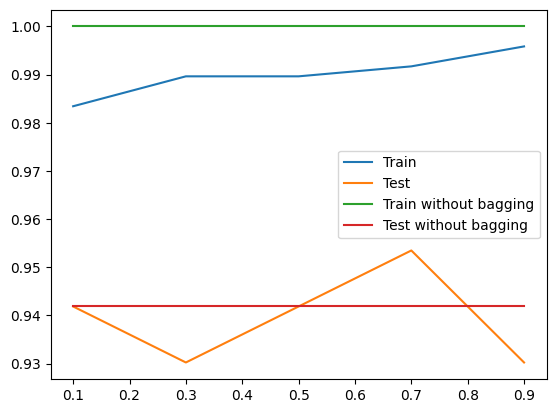

In [80]:
# Test on fraction of examples used to train each base learners

list_n_examples = [0.1, 0.3, 0.5, 0.7, 0.9]

X_train, X_test, y_train, y_test = get_dataset('wdbc')

log_regr = LogisticRegression(penalty=None, max_iter=5000)
log_regr.fit(X_train, y_train)
nobag_tr_acc = log_regr.score(X_train, y_train)
nobag_te_acc = log_regr.score(X_test, y_test)
print(nobag_tr_acc)
print(nobag_te_acc)


list_tr_acc = []
list_te_acc = []
for n_examples in list_n_examples:
    tr_acc, te_acc = bagging_log_regr(X_train, X_test, y_train, y_test, 10, n_examples)
    list_tr_acc.append(tr_acc)
    list_te_acc.append(te_acc)
print(list_tr_acc)
print(list_te_acc)
plot_acc_vs_n_examples(list_n_examples, list_tr_acc, list_te_acc, nobag_tr_acc, nobag_te_acc)

1.0
0.6617647058823529
[0.625, 0.7760416666666666, 0.8567708333333334, 0.9322916666666666, 0.9557291666666666]
[0.5735294117647058, 0.6176470588235294, 0.6323529411764706, 0.6470588235294118, 0.6470588235294118]


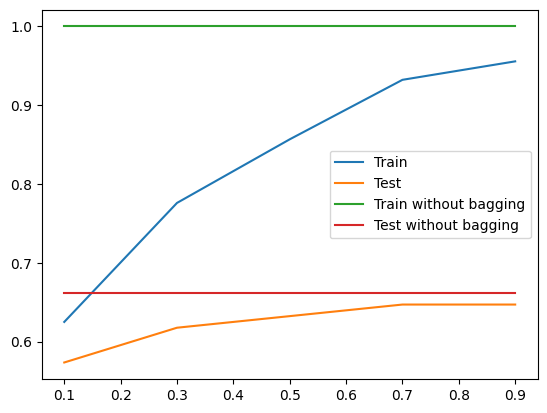

In [81]:
X_train, X_test, y_train, y_test = get_dataset('arrhythmia')

log_regr = LogisticRegression(penalty=None, max_iter=5000)
log_regr.fit(X_train, y_train)
nobag_tr_acc = log_regr.score(X_train, y_train)
nobag_te_acc = log_regr.score(X_test, y_test)
print(nobag_tr_acc)
print(nobag_te_acc)


list_tr_acc = []
list_te_acc = []
for n_examples in list_n_examples:
    tr_acc, te_acc = bagging_log_regr(X_train, X_test, y_train, y_test, 10, n_examples)
    list_tr_acc.append(tr_acc)
    list_te_acc.append(te_acc)
print(list_tr_acc)
print(list_te_acc)
plot_acc_vs_n_examples(list_n_examples, list_tr_acc, list_te_acc, nobag_tr_acc, nobag_te_acc)

In [82]:
# Plots training and test accuracies vs C (inverse of regularization strength)
def plot_acc_vs_C(list_C, list_tr_acc, list_te_acc, list_nobag_tr_acc, list_nobag_te_acc):
    plt.plot(list_C, list_tr_acc, label='Train w/ bagging')
    plt.plot(list_C, list_te_acc, label='Test w/ bagging')
    plt.plot(list_C, list_nobag_tr_acc, label='Train w/o bagging')
    plt.plot(list_C, list_nobag_te_acc, label='Test w/o bagging')
    plt.legend(loc='best')
    plt.show()

[0.9399585921325052, 0.9648033126293996, 0.9772256728778468, 0.9834368530020704, 0.9855072463768116, 0.989648033126294, 0.9917184265010351, 0.9875776397515528]
[0.9418604651162791, 0.9418604651162791, 0.9534883720930233, 0.9534883720930233, 0.9534883720930233, 0.9418604651162791, 0.9302325581395349, 0.9534883720930233]
[0.917184265010352, 0.9544513457556936, 0.9565217391304348, 0.9813664596273292, 0.9834368530020704, 0.9875776397515528, 0.9855072463768116, 0.9875776397515528]
[0.9069767441860465, 0.9534883720930233, 0.9534883720930233, 0.9534883720930233, 0.9534883720930233, 0.9418604651162791, 0.9302325581395349, 0.9186046511627907]


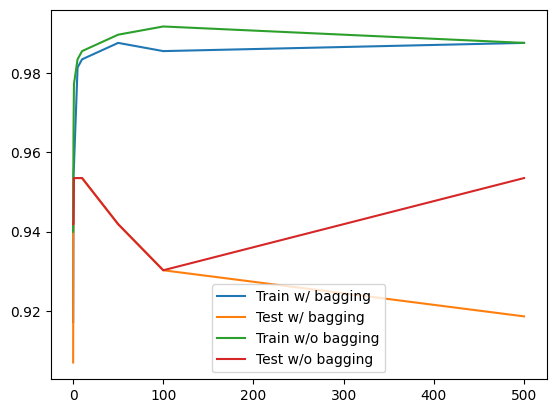

In [83]:
# Test on C

list_C = [0.1, 0.5, 1, 5, 10, 50, 100, 500]

X_train, X_test, y_train, y_test = get_dataset('wdbc')

list_nobag_tr_acc = []
list_nobag_te_acc = []
list_tr_acc = []
list_te_acc = []
for C in list_C:
    log_regr = LogisticRegression(penalty='l2', C=C, max_iter=5000)
    log_regr.fit(X_train, y_train)
    list_nobag_tr_acc.append(log_regr.score(X_train, y_train))
    list_nobag_te_acc.append(log_regr.score(X_test, y_test))
    tr_acc, te_acc = bagging_log_regr(X_train, X_test, y_train, y_test, 10, 0.5, regularization=C)
    list_tr_acc.append(tr_acc)
    list_te_acc.append(te_acc)
print(list_nobag_tr_acc)
print(list_nobag_te_acc)
print(list_tr_acc)
print(list_te_acc)
plot_acc_vs_C(list_C, list_tr_acc, list_te_acc, list_nobag_tr_acc, list_nobag_te_acc)

[0.6432291666666666, 0.7786458333333334, 0.8229166666666666, 0.9375, 0.9609375, 0.9921875, 1.0, 1.0]
[0.5441176470588235, 0.6323529411764706, 0.6617647058823529, 0.6617647058823529, 0.6764705882352942, 0.6764705882352942, 0.6617647058823529, 0.6617647058823529]
[0.5885416666666666, 0.7083333333333334, 0.7317708333333334, 0.8046875, 0.8098958333333334, 0.8333333333333334, 0.8854166666666666, 0.8671875]
[0.47058823529411764, 0.6029411764705882, 0.6176470588235294, 0.6323529411764706, 0.6617647058823529, 0.6764705882352942, 0.6470588235294118, 0.6470588235294118]


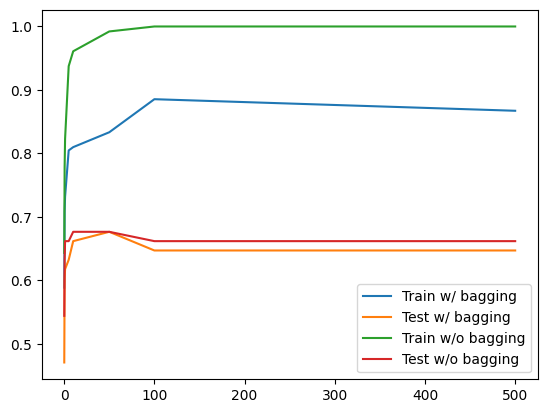

In [84]:
X_train, X_test, y_train, y_test = get_dataset('arrhythmia')

list_nobag_tr_acc = []
list_nobag_te_acc = []
list_tr_acc = []
list_te_acc = []
for C in list_C:
    log_regr = LogisticRegression(penalty='l2', C=C, max_iter=5000)
    log_regr.fit(X_train, y_train)
    list_nobag_tr_acc.append(log_regr.score(X_train, y_train))
    list_nobag_te_acc.append(log_regr.score(X_test, y_test))
    tr_acc, te_acc = bagging_log_regr(X_train, X_test, y_train, y_test, 10, 0.5, regularization=C)
    list_tr_acc.append(tr_acc)
    list_te_acc.append(te_acc)
print(list_nobag_tr_acc)
print(list_nobag_te_acc)
print(list_tr_acc)
print(list_te_acc)
plot_acc_vs_C(list_C, list_tr_acc, list_te_acc, list_nobag_tr_acc, list_nobag_te_acc)